In [100]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 15 14:47:41 2018

@author: niccolop
"""
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk 

#%% load data 
"""
This data was collected on 15th June 2018. They represent the first 10 websites 
suggested by Google from the query "pro life arguments" and "pro choice 
arguments", plus an 11th entry for the each argument as summarized by Wikipedia.
Websites were filtered based on their content: e.g. some pro life arguments 
came after querying for pro choice. Or e.g. some websites had both arguments 
summarized."""
texts=[]
for w in range(10):
    texts.append(open('./data_files/abortion/against/web' + str(w+1) + '.txt', 'r').read())
for w in range(10):
    texts.append(open('./data_files/abortion/pro/web' + str(w+1) + '.txt', 'r').read())
    
#%% clean doc
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
from pprint import pprint  # pretty-printer

# remove urls
texts = [re.sub(r"http\S+", "", doc) for doc in texts]
texts = [' '.join(item for item in doc.split() if not (item.startswith('www.')))  for doc in texts]
# strip trailing symbols
texts = [doc.replace('\n','') for doc in texts]
# remove double quotes
texts = [doc.replace('—',' ').replace('–',' ') for doc in texts]
# remove numbers
texts = [re.sub(r'\d+', '', doc) for doc in texts]
    
# remove punctuation and stopwords
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) | set('“”"’')
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

def clean_sent(doc):
    stop_free = ([i for i in doc.lower().split('.')])
    return stop_free

# tokenize docs
#texts_clean = [clean_sent(doc) for doc in texts]  

texts_clean = [clean_sent(doc) for doc in texts]  

# remove non english words
words = set(nltk.corpus.words.words())
for i,doc in enumerate(texts_clean):
    texts_clean[i] = [w for w in doc if w in words or not w.isalpha()]

# this is useless...
texts_corpus = list(itertools.chain.from_iterable(texts_clean))

#%% 
# Importing Gensim
from gensim import corpora, models, similarities

#Creating the term dictionary of our courpus, where every unique term 
#is assigned an index. 
dictionary_against = corpora.Dictionary(texts_clean[:10]) 
dictionary_pro = corpora.Dictionary(texts_clean[10:]) 
dictionary = corpora.Dictionary(texts_clean) 
# Converting list of documents (corpus) into Document Term Matrix using 
# dictionary prepared above.
corpus_against = [dictionary.doc2bow(doc) for doc in texts_clean[:10]]
corpus_pro = [dictionary.doc2bow(doc) for doc in texts_clean[10:]]

In [107]:
pro = [item for sublist in texts_clean[0:10] for item in sublist]
against = [item for sublist in texts_clean[10:] for item in sublist]

In [319]:
# one sentence
pro[1] # pro = pro life

' millions of american women have aborted a child, and the pain, loss, and emotional need to justify what was done, both on the part of the mother and on the part of her loved ones, is strong and deep'

In [77]:
# a sentence
against[100]

'  peer-reviewed study comparing the mental health of women who received abortions to women denied abortions found that women who were denied abortions "felt more regret and anger" and "less relief and happiness" than women who had abortions'

In [ ]:
import keras
# changes words to numbers
tokenizer = keras.preprocessing.text.Tokenizer(num_words=2000, lower=True,split=" ")
tokenizer.fit_on_texts(pro + against)
p_encoded = tokenizer.texts_to_sequences(pro)
a_encoded = tokenizer.texts_to_sequences(against)

In [113]:
# how one sentence looks like now
print(p_encoded[1])

[1063, 2, 154, 27, 21, 341, 4, 46, 5, 1, 182, 5, 579, 267, 3, 1794, 49, 47, 378, 162, 17, 1, 225, 2, 1, 117, 5, 17, 1, 225, 2, 44, 742, 8, 743, 5, 744]


In [170]:
# transform this into a highdimensional input
from scipy.sparse import csr_matrix
p_enc = np.array([csr_matrix((0*np.array(p)+1, (0*np.array(p), np.array(p))), shape=(1, 2000)).toarray() for p in p_encoded])
a_enc = np.array([csr_matrix((0*np.array(p)+1, (0*np.array(p), np.array(p))), shape=(1, 2000)).toarray() for p in a_encoded])

In [206]:
p_enc = p_enc.squeeze()
a_enc = a_enc.squeeze()

print(p_enc[1])
print(p_enc[1].shape)
X = np.vstack((p_enc,a_enc))
y = np.hstack((p_enc[:,0]*0,a_enc[:,0]*0 + 1)) # i.e. pro-life is 0, pro-choice 1

[ 0.  4.  3. ...,  0.  0.  0.]
(2000,)


## Logistic regression w/ regularization and recursive feature selection 

Optimal number of features : 10


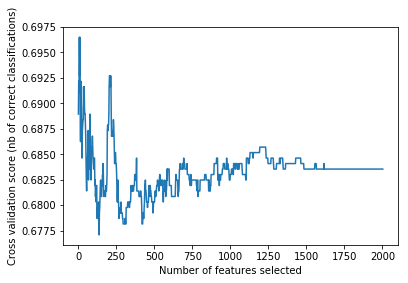

[[1258   20]
 [ 519   58]]


In [250]:
## see here: http://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html 
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.datasets import make_classification

# Create the RFE object and compute a cross-validated score.
lr = linear_model.LogisticRegression(C = .1) # C is the (inverse of) regularizer

# The "accuracy" scoring is proportional to the number of correct
# classifications
stepsize = 2 # num of features eliminated at each step
rfecv = RFECV(estimator=lr, step=stepsize, cv=StratifiedKFold(2),
              scoring='accuracy')
rfecv.fit(X, y)

print("Optimal number of features : %d" % (rfecv.n_features_))

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(np.arange(1, len(rfecv.grid_scores_) + 1)*stepsize, rfecv.grid_scores_)
plt.show()

from sklearn.metrics import confusion_matrix
y_true = y
y_pred = rfecv.predict(X)
print(confusion_matrix(y_true, y_pred))

In [295]:
# print the selected features
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print([reverse_word_map[k] for k in np.nonzero(rfecv.support_)[0]])
print(["{0:.2f} ".format(k) for k in rfecv.get_params()['estimator'].fit(X[:,rfecv.support_],y).coef_[0]])

['pro', '”', 'human', 'right', 'i', 'abortions', 'child', 'choice', 'religious', 'common']
['-0.70 ', '-0.81 ', '-0.76 ', '0.70 ', '0.64 ', '0.74 ', '0.79 ', '0.77 ', '0.56 ', '0.63 ']


In [313]:
# print the selected features
reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
import pandas as pd
df = pd.DataFrame()
df["word"] = [reverse_word_map[k] for k in rfecv.ranking_[:20]]
df["weight"] = [k for k in rfecv.get_params()['estimator'].fit(X[:,rfecv.ranking_[:20]],y).coef_[0]]
print(df.sort_values('weight'))
# high positive weight --> pro-choice
# high negative weight --> pro-life

           word    weight
11    developed -0.282324
18         self -0.201909
4          long -0.196064
6   whittington -0.166589
7      property -0.084171
8   evangelical -0.077722
0          sort -0.050774
5          used -0.048841
3     christian -0.035848
13          the -0.008369
16       others  0.020083
9          here  0.043108
10     detected  0.051624
19        where  0.121685
15        don't  0.140828
12    conceived  0.142932
2         might  0.146781
14         will  0.244797
17       become  0.251528
1        decide  0.411959


## k-NN 

In [ ]:
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)